# Install and Load Library

In [1]:
%pip install yfinance

In [16]:
import yfinance as yf

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout

# Load dataset

In [109]:
# Download data saham MPMX
data = yf.download('MPMX.JK', start='2024-01-01', end='2024-12-11')

# Simpan ke file CSV
data.to_csv('MPMX_data.csv')
print("Data saham MPMX berhasil diunduh!")

[*********************100%***********************]  1 of 1 completed

Data saham MPMX berhasil diunduh!


In [110]:
raw = pd.read_csv('MPMX_data.csv')[2:]  # 2 baris pertama merupakan header excel
# raw.head()
raw.sample(frac = 1).head()

,Price,Adj Close,Close,High,Low,Open,Volume
196,2024-10-28,1020.0,1020.0,1035.0,1020.0,1035.0,4173000
5,2024-01-05,958.3726196289062,1075.0,1080.0,1070.0,1075.0,13799500
224,2024-12-06,990.0,990.0,995.0,985.0,990.0,1293500
198,2024-10-30,1025.0,1025.0,1025.0,1015.0,1020.0,3639500
182,2024-10-08,1035.0,1035.0,1035.0,1020.0,1025.0,3986200


# Pre-processing Dataset

In [111]:
# Drop unused columns

raw.drop(["Adj Close", "Price", "Volume"], axis=1, inplace=True)
raw.head()

,Close,High,Low,Open
2,1050.0,1055.0,1040.0,1050.0
3,1075.0,1085.0,1050.0,1050.0
4,1075.0,1090.0,1070.0,1075.0
5,1075.0,1080.0,1070.0,1075.0
6,1075.0,1095.0,1070.0,1075.0


In [112]:
dataset = raw.values
dataset[:5]

array([['1050.0', '1055.0', '1040.0', '1050.0'],
       ['1075.0', '1085.0', '1050.0', '1050.0'],
       ['1075.0', '1090.0', '1070.0', '1075.0'],
       ['1075.0', '1080.0', '1070.0', '1075.0'],
       ['1075.0', '1095.0', '1070.0', '1075.0']], dtype=object)

In [113]:
# Normalisasi

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data[:5]

array([[0.81818182, 0.74193548, 0.80645161, 0.8125    ],
       [0.96969697, 0.93548387, 0.87096774, 0.8125    ],
       [0.96969697, 0.96774194, 1.        , 0.96875   ],
       [0.96969697, 0.90322581, 1.        , 0.96875   ],
       [0.96969697, 1.        , 1.        , 0.96875   ]])

# Train-Test Splitting

In [114]:
training_data_len = math.ceil(len(dataset) * .8)
train_data = scaled_data[0:training_data_len, :]
len(train_data)

180

In [115]:
# Check data shape

np.array(train_data).shape

(180, 4)

In [116]:
# Prepare data for training

x_train = []
y_train = []

for i in range(100, len(train_data)):
    # Use data of 100 days before to be the x
    x_train.append(train_data[i-100:i])
    prev_close = train_data[i-1, 0]
    cur_close = train_data[i, 0]
    # Labelling y as Naik, Tetap, Turun
    if cur_close > prev_close:
        y_train.append(2)   # Naik
    elif (cur_close == prev_close):
        y_train.append(1)   # Tetap
    else:
        y_train.append(0)   # Turun

In [117]:
print(len(x_train), len(y_train))

80 80


In [118]:
# Check x train

x_train[0]

array([[0.81818182, 0.74193548, 0.80645161, 0.8125    ],
       [0.96969697, 0.93548387, 0.87096774, 0.8125    ],
       [0.96969697, 0.96774194, 1.        , 0.96875   ],
       [0.96969697, 0.90322581, 1.        , 0.96875   ],
       [0.96969697, 1.        , 1.        , 0.96875   ],
       [0.81818182, 0.93548387, 0.80645161, 0.96875   ],
       [0.93939394, 0.87096774, 0.87096774, 0.8125    ],
       [0.96969697, 0.90322581, 1.        , 0.9375    ],
       [0.93939394, 0.90322581, 0.93548387, 0.96875   ],
       [0.87878788, 0.90322581, 0.93548387, 0.9375    ],
       [0.87878788, 0.90322581, 0.93548387, 0.875     ],
       [0.84848485, 0.87096774, 0.90322581, 0.875     ],
       [0.81818182, 0.80645161, 0.83870968, 0.84375   ],
       [0.84848485, 0.77419355, 0.83870968, 0.8125    ],
       [0.78787879, 0.77419355, 0.77419355, 0.84375   ],
       [0.66666667, 0.70967742, 0.67741935, 0.78125   ],
       [0.66666667, 0.61290323, 0.64516129, 0.65625   ],
       [0.66666667, 0.61290323,

In [119]:
# Mengubah data menjadi format numpy array

X_train, Y_train = np.array(x_train), np.array(y_train)

In [120]:
# Reshape to match LSTM input shape

X_train = np.reshape(X_train, (
    X_train.shape[0],
    X_train.shape[1],
    4
))

# Modelling

In [121]:
# Clear previous model (jika ada)
tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(X_train.shape[1], 4)),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    tf.keras.layers.GRU(units=50),
    Dropout(0.3),
    Dense(units=3, activation='softmax')   # 3 label output, softmax as probabilities
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 100)            │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,353 (567.79 KB)

 Trainable params: 145,353 (567.79 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# Compile the model

model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [123]:
# Train the model

history = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    batch_size = 5
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3828 - loss: 1.0957
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3699 - loss: 1.0858
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4232 - loss: 1.0798
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4180 - loss: 1.0508
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4572 - loss: 1.0855
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3960 - loss: 1.0685
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4634 - loss: 1.0475
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4909 - loss: 1.0539
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4053 - loss: 1.0851
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3748 - loss: 1.0888
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4177 - loss: 1.0755
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy:

In [124]:
acc = history.history['accuracy']
loss = history.history['loss']

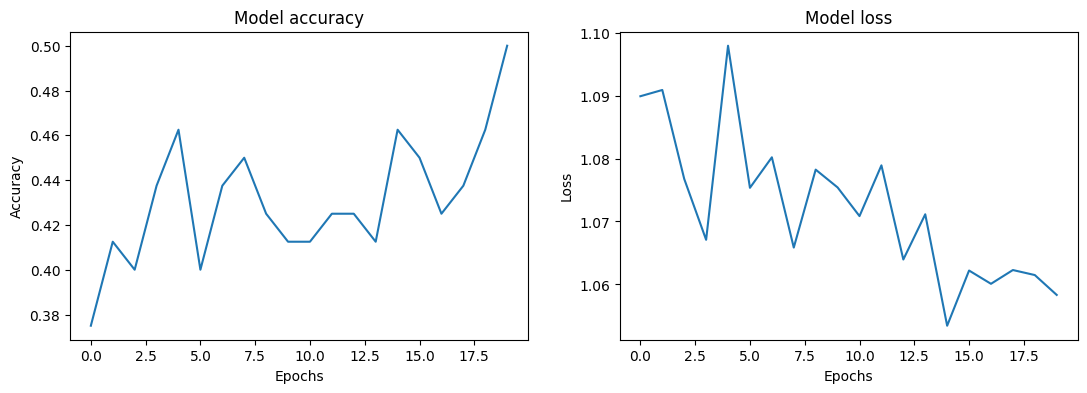

In [125]:
# Plot training & validation accuracy and loss values side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))  # 1 row, 2 columns

# Accuracy plot
ax1.plot(acc)
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

# Loss plot
ax2.plot(loss)
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

plt.show()

# Evaluate Model

In [126]:
test_data = scaled_data[training_data_len-100:, :]

In [127]:
x_test = []
y_test = []

for i in range(100, len(test_data)):
    x_test.append(test_data[i-100:i])
    prev_close = train_data[i-1, 0]
    cur_close = train_data[i, 0]
    if cur_close > prev_close:
        y_test.append(2)
    elif (cur_close == prev_close):
        y_test.append(1)
    else:
        y_test.append(0)

In [128]:
x_test = np.array(x_test)
y_test = np.array(y_test)

# Reshape for matching
x_test = np.reshape(x_test, (
    x_test.shape[0],
    x_test.shape[1],
    4
))

In [129]:
val_loss, val_acc = model.evaluate(x_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4421 - loss: 1.0858 


# Prediction

In [130]:
new_df = raw.copy()

last_100_days = new_df[-100:].values
last_100_days_scaled = scaler.transform(last_100_days)

x_pred = []
x_pred.append(last_100_days_scaled)
x_pred = np.array(x_pred)
x_pred = np.reshape(x_pred, (
    x_pred.shape[0],
    x_pred.shape[1],
    4
))

pred_price = model.predict(x_pred)
labels = ['Turun', 'Tetap', 'Naik']
print(pred_price, labels[np.argmax(pred_price)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
[[0.31990162 0.2588874  0.42121094]] Naik
